## 📊 Análise Exploratória de Dados (EDA)

Esta seção apresenta a exploração estatística e visual do conjunto de dados, com o objetivo de identificar padrões relevantes, avaliar a qualidade das variáveis e fornecer insumos críticos para as etapas de pré-processamento e modelagem supervisionada.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import warnings

from src.config import DADOS_ORIGINAIS, DADOS_TRATADOS
from src.plots import (
    plot_histograms_with_kde,
    plot_violinplots,
    plot_boxplots,
    plot_bar_proportions,
    plot_correlation_matrix
)

sns.set_style("whitegrid")
sns.set_theme(palette="bright")

warnings.filterwarnings("ignore")

### 🔍 Visão Geral do Dataset

O projeto utiliza o **AI4I 2020 Predictive Maintenance Dataset**, disponibilizado publicamente pela UCI Machine Learning Repository. Esta base de dados foi sintetizada com o objetivo de refletir padrões reais observados em cenários industriais de manutenção preditiva, nos quais sensores monitoram continuamente variáveis operacionais de máquinas.

- **Registros:** 10.000
- **Variáveis numéricas contínuas:** Temperatura do ar, temperatura do processo, torque
- **Variáveis numéricas discretas:** Velocidade rotacional, desgaste da ferramenta
- **Variáveis categóricas:** Tipo do produto (`Type`)
- **Alvo principal:** `Target` (para classificação binária: 0 = sem falha, 1 = com falha) ou `Failure Type` (para classificação multiclasse)

In [2]:
# Importa base de dados
df = pd.read_csv(DADOS_ORIGINAIS)

# Remove colunas de ID
df= df.drop(columns=['UDI', 'Product ID'])

# Exibe dataframe
df.head()

,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type
0,M,298.1,308.6,1551,42.8,0,0,No Failure
1,L,298.2,308.7,1408,46.3,3,0,No Failure
2,L,298.1,308.5,1498,49.4,5,0,No Failure
3,L,298.2,308.6,1433,39.5,7,0,No Failure
4,L,298.2,308.7,1408,40.0,9,0,No Failure


### ✅ Qualidade dos Dados

| Critério               | Resultado             |
|------------------------|------------------------|
| Valores nulos          | **Nenhum**            |
| Registros duplicados   | **Nenhum**              |
| Tipagem otimizada      | Sim (downcast + categorias) |
| Uso de memória         | **186 KB** após otimização |

In [ ]:
# Exibe informações do dataframe
df.info()

In [ ]:
# Checagem de valores nulos e duplicados
print("Valores nulos por coluna:\n")
print(df.isnull().sum())
print("\n")
print(f"Linhas duplicadas: {df.duplicated().sum()}")

Valores nulos por coluna:

Type                       0
Air temperature [K]        0
Process temperature [K]    0
Rotational speed [rpm]     0
Torque [Nm]                0
Tool wear [min]            0
Target                     0
Failure Type               0
dtype: int64


Linhas duplicadas: 0


In [ ]:
# Separa colunas em numéricas ou categóricas
num_cols = df.select_dtypes(include=[np.number]).columns
cat_cols = df.select_dtypes(include=["object"]).columns

# Separa colunas numéricas em int ou float
int_cols = df.select_dtypes(include='integer').columns
float_cols = df.select_dtypes(include='float').columns

# Downcast das colunas
df[int_cols] = df[int_cols].apply(pd.to_numeric, downcast='integer')
df[float_cols] = df[float_cols].apply(pd.to_numeric, downcast='float')
df[cat_cols] = df[cat_cols].astype('category')

# Exibe o uso de memória do dataframe em KB após downcast
print(f"Uso de memória do dataframe: {df.memory_usage().sum() / 1024:.1f} KB")

Uso de memória do dataframe: 186.0 KB


In [ ]:
# Separa colunas preditoras e alvo
X = df.drop(columns=['Target', 'Failure Type'])
y_binary = df['Target']
y_multiclass = df['Failure Type']

### 📈 Distribuição das Variáveis Numéricas

Abaixo, a análise das cinco variáveis numéricas mais relevantes, avaliando comportamento geral e relação com a variável alvo (`Target`):

#### 🌡️ Air Temperature [K]
- Média: 300.00 | Desvio padrão: 2.00
- A classe com falha ocorre mais frequentemente em temperaturas **ligeiramente acima da média**.
- **Insight:** Pode indicar falhas associadas a ambientes menos controlados termicamente.

#### 🔥 Process Temperature [K]
- Média: 310.01 | Desvio padrão: 1.48
- Padrão semelhante ao da temperatura ambiente, com falhas mais frequentes **acima de 311 K**.
- **Insight:** Reforça o impacto de temperatura excessiva no risco de falha.

#### 🔄 Rotational Speed [rpm]
- Média: 1538.78 | Desvio padrão: 179.28
- Falhas ocorrem com mais frequência em rotações **abaixo da média**, mas também em **valores extremos altos**.
- **Insight:** Relação possivelmente não linear com a falha (formato de U invertido).

#### ⚙️ Torque [Nm]
- Média: 39.99 | Desvio padrão: 9.97
- A classe com falha se concentra em valores **mais altos de torque**.
- **Insight:** Pode indicar esforço excessivo na operação como precursor de falhas.

#### 🛠️ Tool Wear [min]
- Média: 107.95 | Desvio padrão: 63.65
- A variável com maior poder de separação: falhas se concentram fortemente nos **níveis mais altos de desgaste**.
- **Insight:** Desgaste é um forte preditor de falha e deve ser priorizado na modelagem.

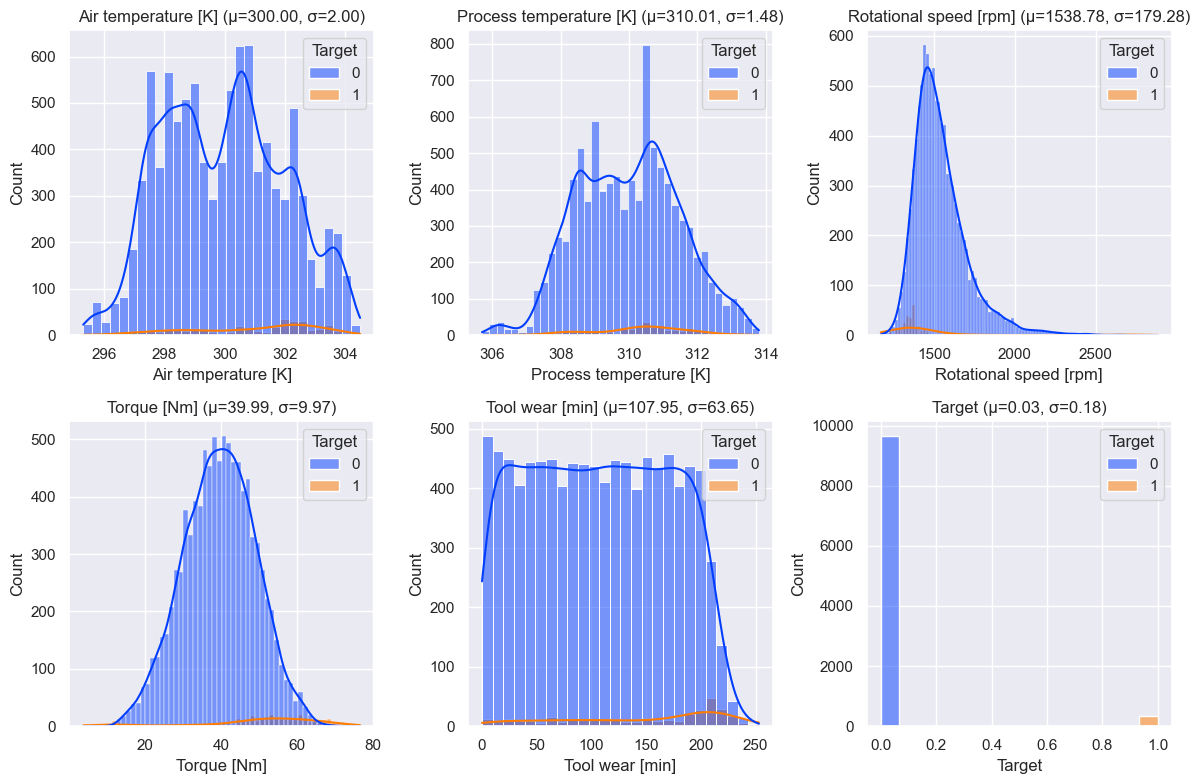

In [ ]:
# Histogramas com KDE
plot_histograms_with_kde(
    df, num_cols, 
    hue_col='Target'
    )

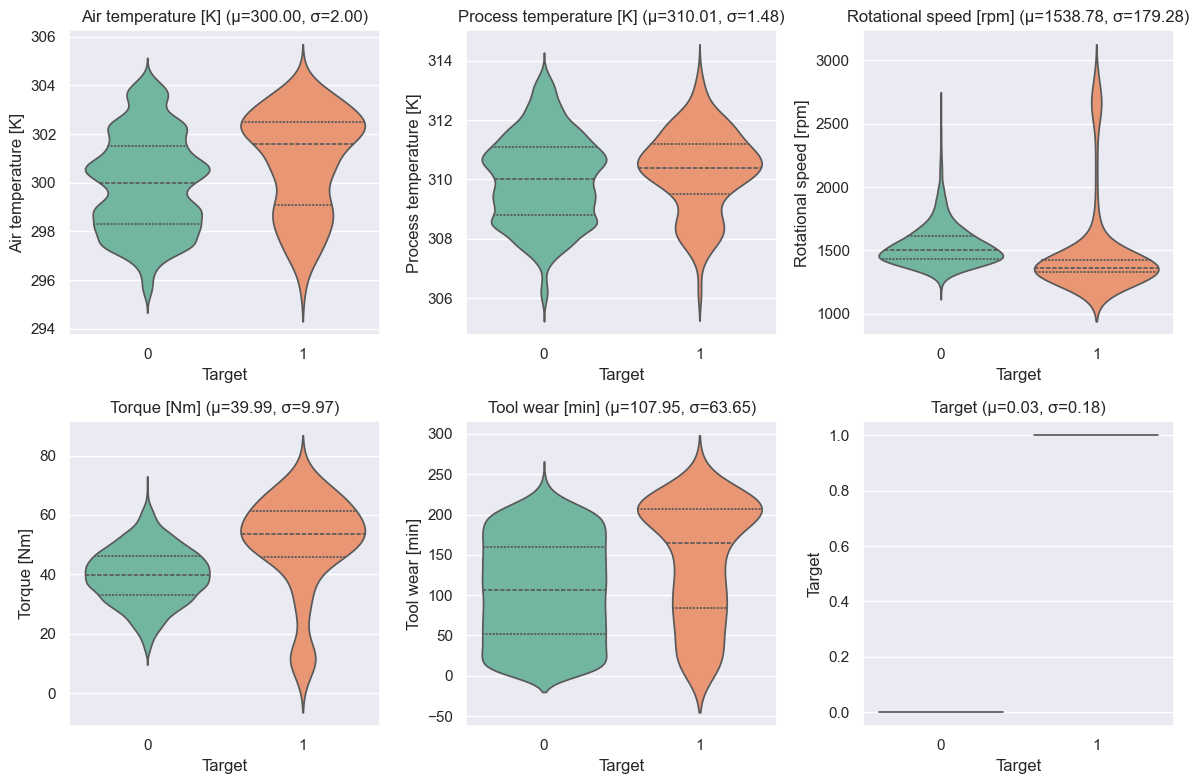

In [ ]:
# Violin plots
plot_violinplots(
    df, num_cols, 
    'Target'
    )

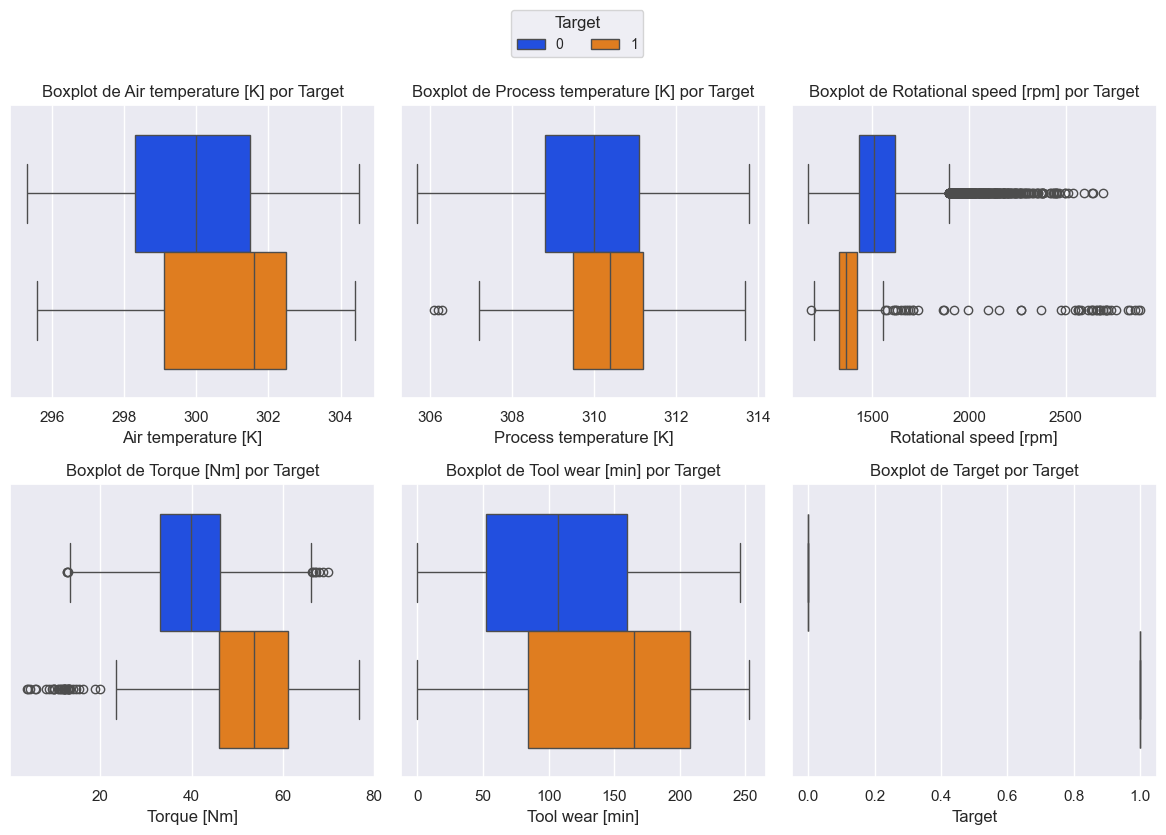

In [ ]:
# Boxplots por target
plot_boxplots(
    df, num_cols, 
    'Target', 
    )

### 🧪 Análise por Tipo de Falha (`Failure Type`)

Para os casos em que a falha ocorreu (`Target = 1`), foi realizada uma análise segmentada por `Failure Type`, permitindo identificar padrões específicos por tipo de ocorrência:

| Variável            | Padrões observados por tipo de falha                                                                 |
|---------------------|--------------------------------------------------------------------------------------------------------|
| **Air Temp.**       | `Heat Dissipation Failure` ocorre em valores mais altos que os demais                                 |
| **Process Temp.**   | Mesmo padrão acima; reforça natureza térmica da falha                                                 |
| **Rotational Speed**| `Power Failure` em rotações muito altas; `Heat Dissipation` e `Overstrain` mais próximas a rotações baixas   |
| **Torque**          | `Power Failure` e `Overstrain` com torques mais elevados, `Heat Dissipation` em extremos (altos e baixos)    |
| **Tool Wear**       | `Power Failure` e `Tool Wear Failure` ocorrem com alto desgaste, não houveram casos de falha precoce (baixo desgaste)   |

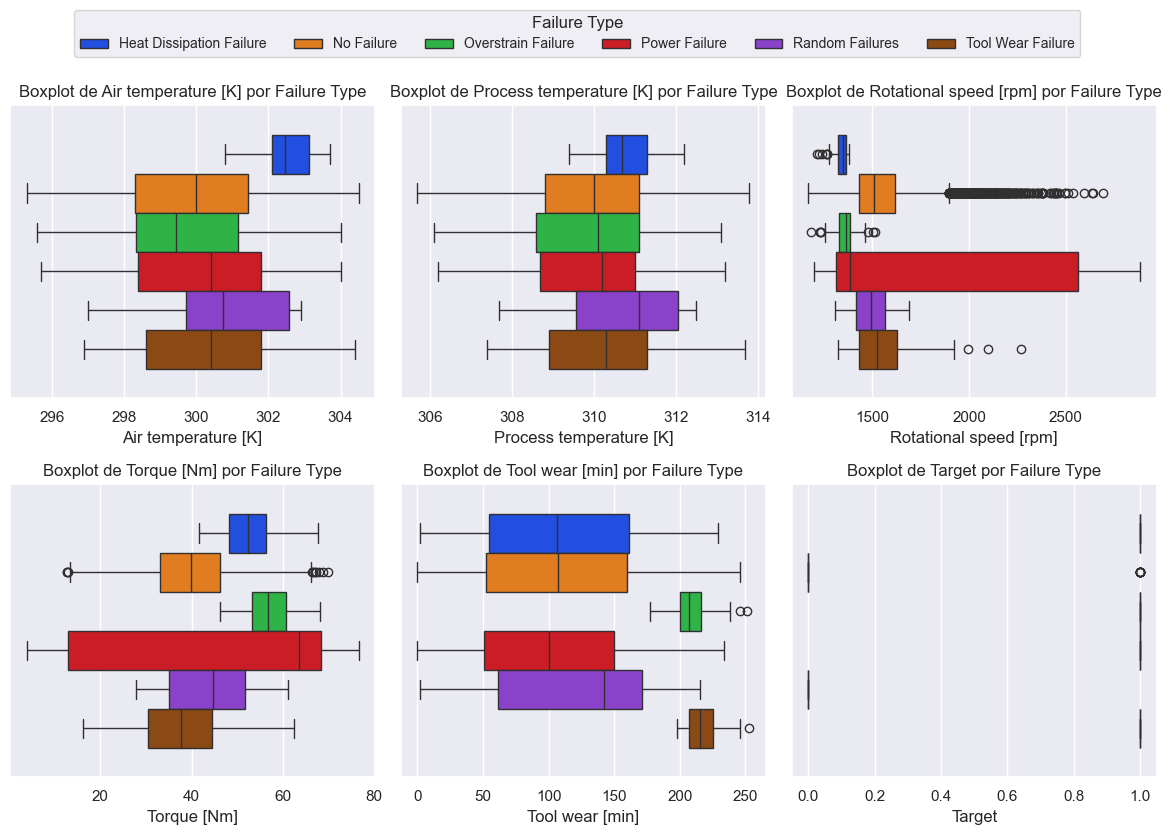

In [ ]:
# Boxplots por tipo de falha
plot_boxplots(
    df=df,
    cols=num_cols,
    group_col='Failure Type',
    n_cols=3,
)

### ⚖️ Distribuição da Variável Alvo

- **Classe 0 (sem falha):** 96,61%
- **Classe 1 (com falha):** 3,39%

> **Conclusão:** O conjunto é altamente desbalanceado, o que impactará diretamente nas estratégias de modelagem (uso de técnicas como SMOTE ou ajuste de pesos).

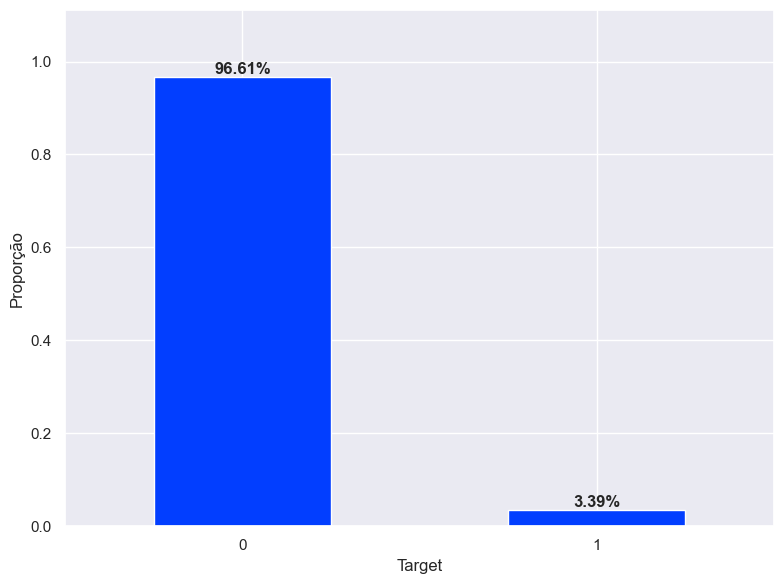

In [ ]:
# Proporção do target
plot_bar_proportions(df, 'Target', figsize=(8, 6))

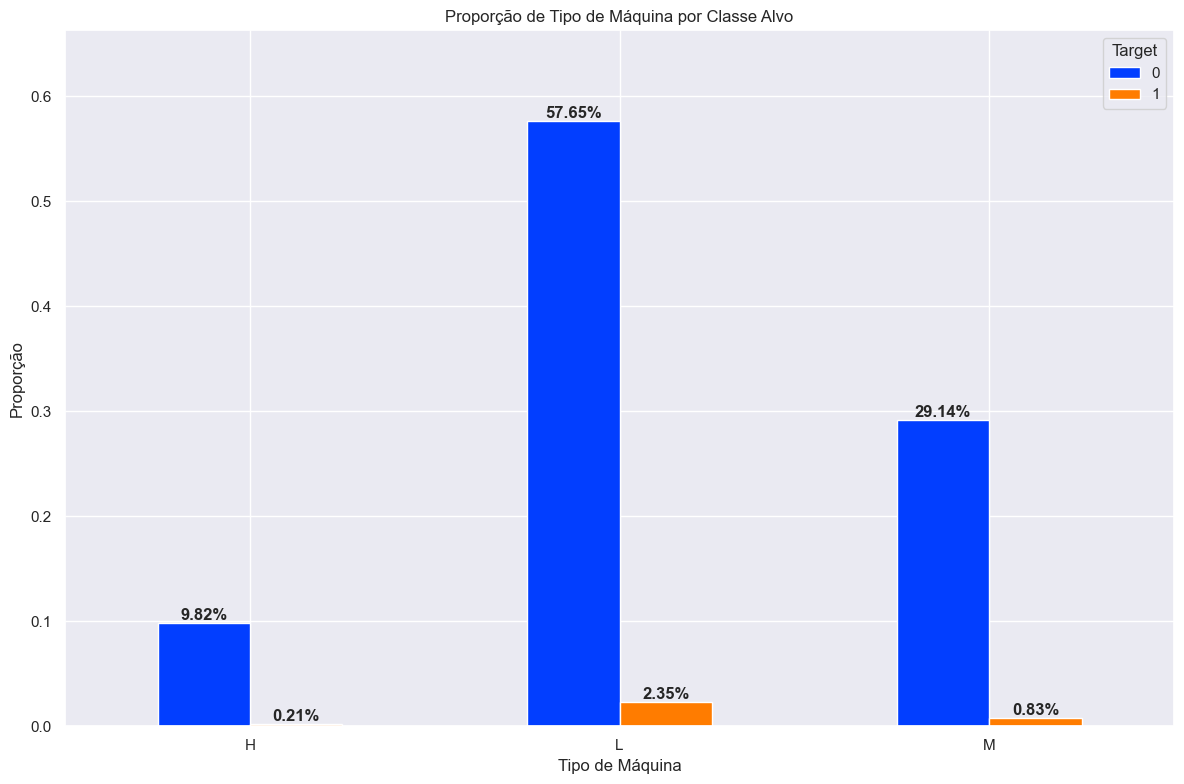

In [ ]:
# Proporção de Tipo de Máquina por Classe Alvo
plot_bar_proportions(
    df=df,
    x_col='Type',
    group_col='Target',
    title='Proporção de Tipo de Máquina por Classe Alvo',
    xlabel='Tipo de Máquina'
)

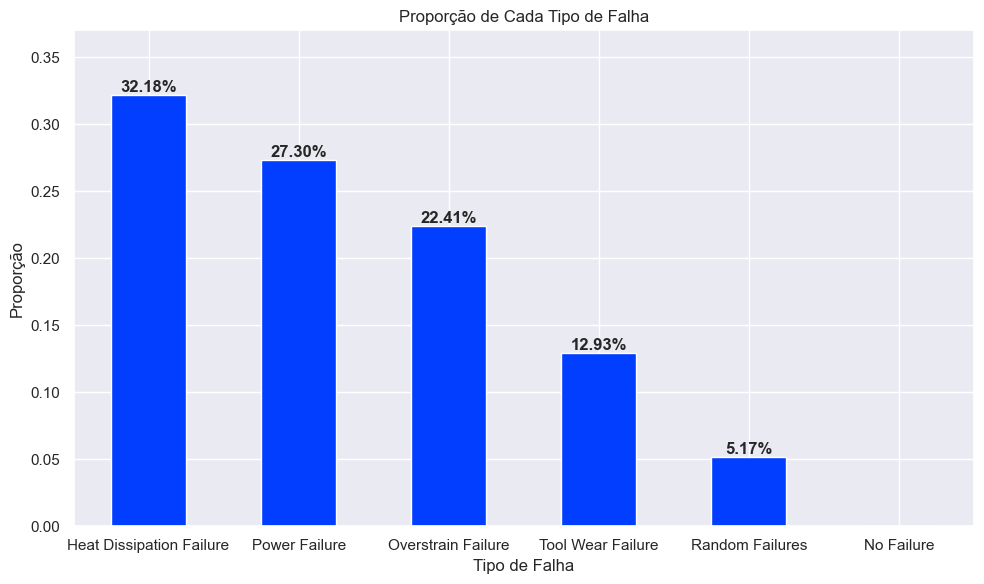

In [ ]:
# Filtra apenas os registros com falha
df_failures = df[df['Failure Type'] != "No Failure"]

# Gera o gráfico de barras com proporções por tipo de falha
plot_bar_proportions(
    df=df_failures,
    x_col='Failure Type',
    title='Proporção de Cada Tipo de Falha',
    xlabel='Tipo de Falha',
    figsize=(10, 6)
)


### 🔗 Correlação entre Variáveis

A matriz de correlação mostra:

- Correlação **forte positiva** entre `Air Temperature` e `Process Temperature` (r ≈ 0.88)
- Correlação **forte negativa** entre `Torque` e `Rotational Speed` (r ≈ -0.88)
- `Tool Wear` apresenta **baixa correlação com as demais variáveis**

> **Conclusão:** A ausência de multicolinearidade crítica favorece o uso de modelos baseados em árvore, sem necessidade urgente de técnicas de redução de dimensionalidade.

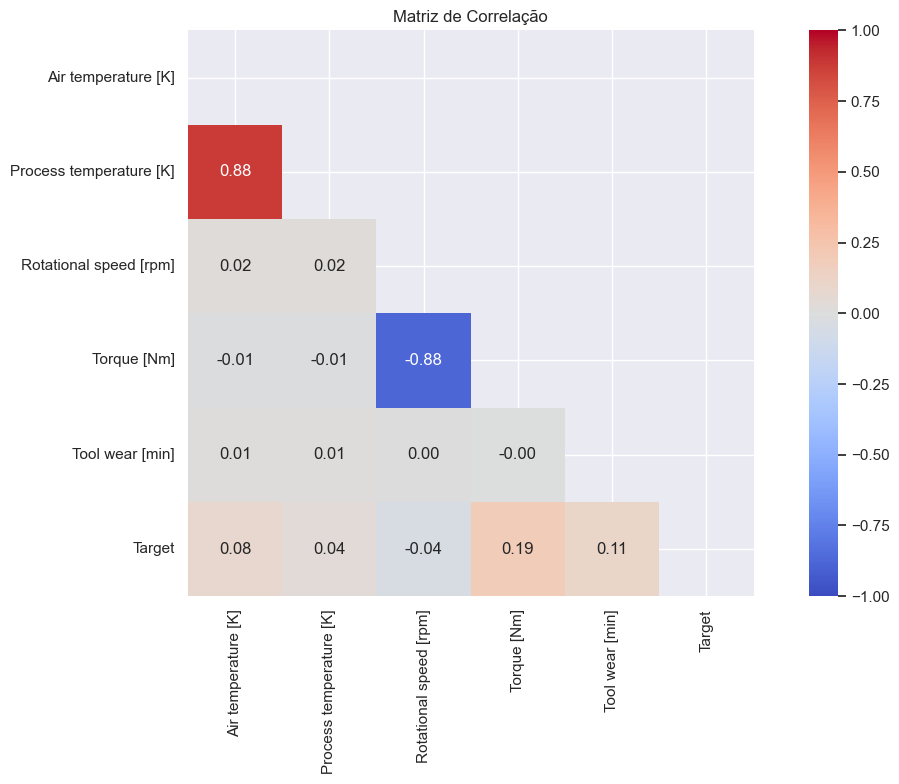

In [ ]:
# Matriz de correlação
plot_correlation_matrix(df, num_cols)

In [ ]:
# Exportação da base tratada
df.to_csv(DADOS_TRATADOS, index=False)

### 📈 Insights Principais

#### Para Modelagem

1. **Desbalanceamento de classes**: Necessidade de técnicas específicas como oversampling, undersampling ou algoritmos que lidem com classes desbalanceadas
2. **Qualidade dos dados**: Ausência de valores nulos e duplicatas facilita o pré-processamento
3. **Tipos de falha distintos**: Cada tipo de falha apresenta padrões específicos nas variáveis operacionais

#### Para Negócio

1. **Prevenção de falhas**: Identificação precoce de padrões anômalos pode reduzir custos de manutenção
2. **Qualidade do produto**: Tipo de máquina influencia significativamente a probabilidade de falha
3. **Monitoramento contínuo**: Variáveis como temperatura e torque são indicadores importantes de saúde da máquina